In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm import tqdm
import pickle
import os

## **Different Classification Model**

### **Data Processing**

In [30]:
# Import the dataset
def get_data():
    """
    Load SEED data from .npz file.
    
    :return: train data, test data, train labels, test labels.
    """
    feature_1s_dir = './EEG-DE-feature/eeg_used_1s'
    file_1s_list = os.listdir(feature_1s_dir)
    file_1s_list.sort()
    
    all_train_data = {key: [] for key in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
    all_test_data = {key: [] for key in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
    all_train_labels = []
    all_test_labels = []
    
    for item in tqdm(file_1s_list, desc="Loading data"):
        npz_data = np.load(os.path.join(feature_1s_dir, item))
        
        # Extract train and test data
        train_data = pickle.loads(npz_data['train_data'])
        test_data = pickle.loads(npz_data['test_data'])
        
        # Append data from this file to the overall dictionary
        for key in all_train_data.keys():
            all_train_data[key].append(train_data[key])
            all_test_data[key].append(test_data[key])
        
        all_train_labels.append(npz_data['train_label'])
        all_test_labels.append(npz_data['test_label'])
        
    # Combine train and test data across all files
    train_data = {key: np.concatenate(all_train_data[key], axis=0) for key in all_train_data.keys()}
    test_data = {key: np.concatenate(all_test_data[key], axis=0) for key in all_test_data.keys()}
    train_labels = np.concatenate(all_train_labels, axis=0)
    test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Combine features from all bands into a single feature vector
    trainX = np.hstack([train_data[key] for key in train_data.keys()])
    testX = np.hstack([test_data[key] for key in test_data.keys()])
    
    # Debug information
    # print("Combined Train Data Shape:", trainX.shape)
    # print("Combined Test Data Shape:", testX.shape)
    # print("Combined Train Labels Shape:", train_labels.shape)
    # print("Combined Test Labels Shape:", test_labels.shape)
    
    return trainX, testX, train_labels, test_labels

In [31]:

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = get_data()


Loading data:   0%|          | 0/36 [00:00<?, ?it/s]

Loading data: 100%|██████████| 36/36 [00:02<00:00, 15.22it/s]


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

# Train and evaluate models
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[model_name] = accuracy_score(y_test, y_pred)

In [33]:
print(scores)

{'Decision Tree': 0.6043874438021837, 'Random Forest': 0.7619018946692357, 'Support Vector Machine': 0.7259352922286448, 'KNN': 0.6900489723827874, 'Gaussian Naive Bayes': 0.4547406872190109}


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bars

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming X_train, X_test, y_train, y_test are already loaded and preprocessed
# Convert data to PyTorch tensors and move them to the device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define function to create DataLoader
def create_dataloader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = create_dataloader(X_train, y_train)
test_loader = create_dataloader(X_test, y_test, batch_size=len(X_test))  # Using full batch for evaluation

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim // 2 * 64, 100)
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.unsqueeze(1))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, 50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, output_dim)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# Training and evaluation function
def train_evaluate_dl_model(model, train_loader, test_loader, epochs=10, batch_size=32, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)  # Move model to device (GPU or CPU)
    model.train()
    
    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to device
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(loss=loss.item())

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to device
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_batch).float().mean().item()
    
    return accuracy

input_dim = X_train.shape[1]
output_dim = len(set(y_train.cpu().numpy()))

# Reshape X_train and X_test for RNN and LSTM models
X_train_rnn_lstm = X_train.view(X_train.shape[0], -1, input_dim)
X_test_rnn_lstm = X_test.view(X_test.shape[0], -1, input_dim)

# scores = {}

# Train and evaluate CNN
cnn_model = CNNModel(input_dim, output_dim)
print('Training CNN')
scores['CNN'] = train_evaluate_dl_model(cnn_model, train_loader, test_loader)

# Train and evaluate RNN
rnn_model = RNNModel(input_dim, output_dim)
print('Training RNN')
scores['RNN'] = train_evaluate_dl_model(rnn_model, DataLoader(TensorDataset(X_train_rnn_lstm, y_train), batch_size=32, shuffle=True), DataLoader(TensorDataset(X_test_rnn_lstm, y_test), batch_size=len(X_test), shuffle=False))

# Train and evaluate LSTM
lstm_model = LSTMModel(input_dim, output_dim)
print('Training LSTM')
scores['LSTM'] = train_evaluate_dl_model(lstm_model, DataLoader(TensorDataset(X_train_rnn_lstm, y_train), batch_size=32, shuffle=True), DataLoader(TensorDataset(X_test_rnn_lstm, y_test), batch_size=len(X_test), shuffle=False))

print(scores)


Using device: cuda
Training CNN


Training RNN


Training LSTM


{'Decision Tree': 0.6043874438021837, 'Random Forest': 0.7619018946692357, 'Support Vector Machine': 0.7259352922286448, 'KNN': 0.6900489723827874, 'Gaussian Naive Bayes': 0.4547406872190109, 'CNN': 0.7187299132347107, 'RNN': 0.3171965479850769, 'LSTM': 0.34320810437202454}


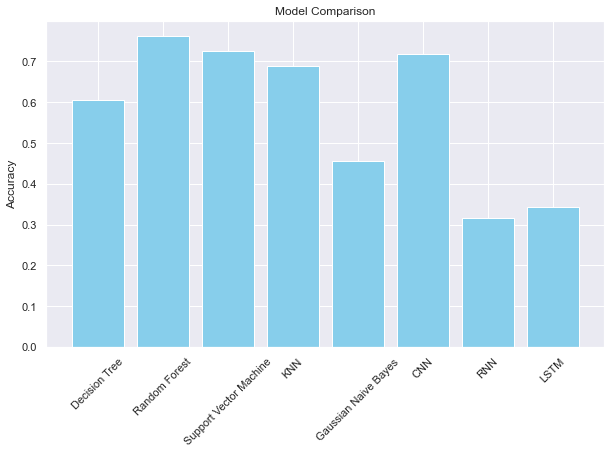

In [35]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(scores.keys(), scores.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()

In [36]:
print(scores)

{'Decision Tree': 0.6043874438021837, 'Random Forest': 0.7619018946692357, 'Support Vector Machine': 0.7259352922286448, 'KNN': 0.6900489723827874, 'Gaussian Naive Bayes': 0.4547406872190109, 'CNN': 0.7187299132347107, 'RNN': 0.3171965479850769, 'LSTM': 0.34320810437202454}
